# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# load these packages
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, classification, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## **Question 1 (10 pts):** 
Choose the best model based on accuracy between multilayer perceptrons predicting whether a face is from an `old` person or not based on `pixels`. Compare the following architectures:

 1. No hidden layers
 1. One hidden layer with 10 neurons
 1. Two Hidden layers with 30 neurons each

Fit both models to `training` and estimate the AUC on validation. You don't need to build a Pipeline because the features needed are in the column `pixels`. Pick the best one based on validation performance. The input dimension is 2304 (=48\*48) and the output is 2. Store the first, second, and third models in the variables `mlp_model1`, `mlp_model2`, and `mlp_model3`. Additionally, fit a logistic regression model and call it `lr_model`. Store the AUC on `AUC1`, `AUC2`, `AUC3`, and `AUC_lr`. Based on these performances, store the best model in `best_model`. Use the default paramerts for all the neural networks.

**Detecting an old or young face based on an image**

We will use the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview) dataset to predict whether an animal is a cat or a dog based on an image. The dataset is already preprocessed and put in a parquet file. The schema of the parquet is as follows:

- `dog`: 1 = dog and 0 = cat
- `id`: Identifier for the image
- `label`: Whether there is a dog or cat in the image
- `pixels`: flatten version of a 48 by 48 pixel image

In [2]:
# read data
# pixels: 48x48 pixel gray values (between 0 and 255) 
cats_dogs = spark.read.parquet('/datasets/cats_dogs.parquet')

# use these splits throughout the homework
training, validation, testing = cats_dogs.randomSplit([0.6, 0.3, 0.1], seed=0)

# to compute AUC use the following evaluator
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='dog')

In [3]:
# utility function to display the first element of a Spark dataframe as an image
def display_first_as_img(df):
    plt.figure()
    plt.imshow(df.first().pixels.reshape([48,48]), 'gray');

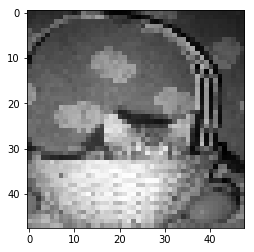

In [4]:
# show random faces
display_first_as_img(cats_dogs.where('dog=0').orderBy(fn.rand()))

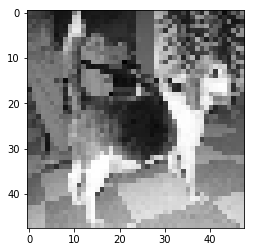

In [5]:
# show random faces
display_first_as_img(cats_dogs.where('dog=1').orderBy(fn.rand()))

In [6]:
#Having a look at the data to know about the output column mainly (it is "dog" here, MLP by default takes it as "label"):

training.show(10)

+---+----+-----+--------------------+
|dog|  id|label|              pixels|
+---+----+-----+--------------------+
|  0| 221|  cat|[64.0,78.0,104.0,...|
|  0| 360|  cat|[144.0,124.0,144....|
|  0| 792|  cat|[62.0,41.0,44.0,1...|
|  0|1072|  cat|[134.0,141.0,143....|
|  0|1131|  cat|[76.0,72.0,87.0,8...|
|  0|1167|  cat|[51.0,51.0,52.0,5...|
|  0|1193|  cat|[61.0,64.0,70.0,7...|
|  0|1347|  cat|[1.0,1.0,1.0,1.0,...|
|  0|1777|  cat|[101.0,95.0,82.0,...|
|  0|1782|  cat|[93.0,101.0,105.0...|
+---+----+-----+--------------------+
only showing top 10 rows



In [7]:
# YOUR CODE HERE
from pyspark.ml import classification

#MultiLayerPerceptron will default output columns to "label", so had to override that cause our output column is "dog"

#MLP with no hidden layer:
mlp1=classification.MultilayerPerceptronClassifier(featuresCol="pixels",labelCol="dog",seed=0)
mlp1=mlp1.setLayers([48*48,2])
mlp_model1=mlp1.fit(training)

#MLP with 1 hidden layer having 10 neurons:
mlp2=classification.MultilayerPerceptronClassifier(featuresCol="pixels",labelCol="dog",seed=0).setFeaturesCol("pixels")
mlp2=mlp2.setLayers([48*48,10,2])
mlp_model2=mlp2.fit(training)

#MLP with 2 hidden layers having 30 neurons each:
mlp3=classification.MultilayerPerceptronClassifier(featuresCol="pixels",labelCol="dog",seed=0).setFeaturesCol("pixels")
mlp3=mlp3.setLayers([48*48,30,30,2])
mlp_model3=mlp3.fit(training)

#Logistic regression model:
lr_model=classification.LogisticRegression(labelCol="dog",featuresCol="pixels").fit(training)
#raise NotImplementedError()

In [8]:
#Area Under Curve for 1st MLP:
AUC1=evaluator.evaluate(mlp_model1.transform(validation))

#Area Under Curve for 2nd MLP:
AUC2=evaluator.evaluate(mlp_model2.transform(validation))

#Area Under Curve for 3rd MLP:
AUC3=evaluator.evaluate(mlp_model3.transform(validation))

#Area Under Curve for Logistic Regression:
AUC_lr=evaluator.evaluate(lr_model.transform(validation))

In [9]:
#Assigning best_model based on the AUC:

auc_list=[AUC1,AUC2,AUC3,AUC_lr]
if max(auc_list)==AUC1:
    best_model=mlp_model1
elif max(auc_list)==AUC2:
    best_model=mlp_model2
elif max(auc_list)==AUC3:
    best_model=mlp_model3
else:
    best_model=lr_model

In [10]:
# 10 points
assert type(mlp_model1) == classification.MultilayerPerceptronClassificationModel
assert type(mlp_model2) == classification.MultilayerPerceptronClassificationModel
assert type(mlp_model3) == classification.MultilayerPerceptronClassificationModel
assert (type(best_model) == classification.MultilayerPerceptronClassificationModel or 
        type(best_model) == classification.LogisticRegressionModel)


## **Question 2 (10 pts):** 
See the notebook in the IST 718 repository for the deep learning section. Build a model for the caltech101 dataframe created below where you are trying to predict whether an object is a face or not. Use a multi-layer perceptron with one hidden layer with 30 neurons. The input image is 60 by 40. Assign the estimated model to the variable `face_model` and use the evaluator defined below to estimate its AUC and store it in `AUC_face`

In [11]:
# the following dataframe will have the the caltech dataset with the pixels in column pixels and the
# label is_face = 1 if the pixels are of a face and 
caltech101_df = spark.read.parquet('/datasets/caltech101_60_40_ubyte.parquet').\
    select(fn.col('raw_pixels').alias('pixels'), 
           ((fn.col('category') == "Faces_easy") | (fn.col('category') == "Faces")).cast('int').alias('is_face'))

caltech101_df = caltech101_df.where('is_face = 0').limit(400).\
    union(caltech101_df.where('is_face = 1').limit(400)).\
    cache()

caltech_training, caltech_evaluation = caltech101_df.randomSplit([0.8, 0.2], seed=0)

# use this evaluator to compute the AUC on validation
evaluator_face = evaluation.BinaryClassificationEvaluator(labelCol='is_face')

In [12]:
# example what caltech_training and caltech_evaluation have
caltech_evaluation.printSchema()

root
 |-- pixels: vector (nullable = true)
 |-- is_face: integer (nullable = true)



In [13]:
#Having a look at the data. The output column, is_face, has 2 levels only; 0 or 1:

caltech_evaluation.show(10)
caltech_evaluation.select(fn.countDistinct("is_face")).show()

+--------------------+-------+
|              pixels|is_face|
+--------------------+-------+
|[0.0,0.0,2.0,3.0,...|      0|
|[0.0,2.0,5.0,5.0,...|      0|
|[0.0,3.0,2.0,2.0,...|      0|
|[1.0,2.0,4.0,5.0,...|      0|
|[1.0,3.0,1.0,1.0,...|      0|
|[1.0,3.0,2.0,1.0,...|      0|
|[1.0,3.0,2.0,3.0,...|      0|
|[1.0,4.0,2.0,3.0,...|      0|
|[1.0,5.0,3.0,7.0,...|      0|
|[1.0,5.0,5.0,2.0,...|      0|
+--------------------+-------+
only showing top 10 rows

+-----------------------+
|count(DISTINCT is_face)|
+-----------------------+
|                      2|
+-----------------------+



In [14]:
# YOUR CODE HERE

#MLP with 1 hidden layer of 30 neurons:
face_mlp=classification.MultilayerPerceptronClassifier(featuresCol="pixels",labelCol="is_face",seed=0)
face_mlp=face_mlp.setLayers([60*40,30,2])
face_model=face_mlp.fit(caltech_training)

#AUC for the said MLP:
AUC_face=evaluator_face.evaluate(face_model.transform(caltech_evaluation))

#raise NotImplementedError()

In [15]:
# 10 points
assert type(face_model) == classification.MultilayerPerceptronClassificationModel
assert len(face_model.layers) == 3
assert AUC_face > 0.5

## **Question 3 (10 pts):** 

Using the boilerplate code provided below, find four images of objects online (the image URLs) one for each of case corresponding to a true positive, true negative, false positive, and false negative. Use the model from Question 2 (`face_model`). Remember that you are predicting `is_face = 1` so a "positive" case is being face and a negative is being not a face. A true positive is "the model predicts face and image is a face", false negative is "the model predict not a face but image is a face". The images that you find must be fair in that they must be similar to the ones in the training dataset. The professor provides one true positive URL and one true negative URL as examples but you still must provide another set of true positive and true negative. Store the the URL of your cases in `TP_URL`, `TN_URL`, `FP_URL`, and `FN_URL`.

In [16]:
from PIL import Image
import requests
from io import BytesIO
from pyspark.ml.linalg import Vectors
import numpy as np

def get_image(url):
    # face
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    shrinked_img = np.array(img.resize([60, 40]).convert('P'))
    return shrinked_img
                          
def display_image(url):
    plt.figure()
    plt.imshow(get_image(url), 'gray')
    plt.show()

def predict_image(model, url):
    new_image = get_image(url).flatten()
    new_img_df = spark.createDataFrame([[Vectors.dense(new_image)]], ['pixels'])
    return model.transform(new_img_df)

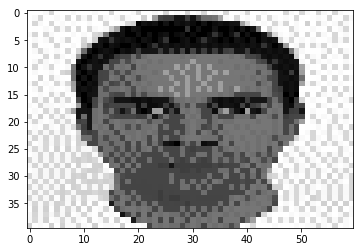

In [17]:
# POSITIVE (face)
face_url = "https://www.uni-regensburg.de/Fakultaeten/phil_Fak_II/Psychologie/Psy_II/beautycheck/english/durchschnittsgesichter/m(01-32)_gr.jpg"
display_image(face_url)

In [18]:
# TRUE POSITIVE: face predicted
predict_image(face_model, face_url).show()

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[225.0,225.0,225....|[-2.7241717679970...|[0.01365070421933...|       1.0|
+--------------------+--------------------+--------------------+----------+



In [19]:
# Example: NEGATIVE (motorcycle)

#I did not edit the code in ths block and the following block, but I am getting an error:
motorcycle_url = 'http://imagesvc.timeincapp.com/v3/foundry/image/?q=70&w=1440&url=https%3A%2F%2Ftimedotcom.files.wordpress.com%2F2017%2F11%2Farch-1s-full-right-side.jpg%3Fquality%3D85'
display_image(motorcycle_url)

OSError: cannot identify image file <_io.BytesIO object at 0x7f3e9bd7f308>

<Figure size 432x288 with 0 Axes>

In [20]:
# TRUE NEGATIVE 
predict_image(face_model, motorcycle_url).show()

OSError: cannot identify image file <_io.BytesIO object at 0x7f3e9b43fa98>

In [21]:
# YOUR CODE HERE

#An actual face picture:
TP_URL="https://kottke.org/plus/misc/images/ai-faces-01.jpg"

#A motorcycle picture:
TN_URL="https://images.ctfassets.net/x7j9qwvpvr5s/3Tm1FcXCGseywq8MSwGGO/855f5550af8ef5caeecfb164f99749e7/Monster-821-MY18-Red-01-Model-Preview-1050x650.png"

#This image could not be identified incorrectly, so did not use it:
#FP_URL="https://images-na.ssl-images-amazon.com/images/I/812Dn8N3gBL._AC_SY879_.jpg"

#A picture of a mask that looks like a face:
FP_URL="https://i.dailymail.co.uk/i/pix/2016/12/23/11/3B977CAD00000578-4061098-image-m-9_1482491371774.jpg"

#A picture of a sketch with an actual human face:
FN_URL="https://i.pinimg.com/474x/5a/6c/d3/5a6cd3863863ee46fafd540493515c08--face-sketch-human-faces.jpg"

#raise NotImplementedError()

True positive


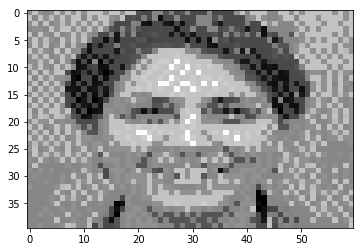

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[103.0,139.0,103....|[-1.0912297421982...|[0.19170478460209...|       1.0|
+--------------------+--------------------+--------------------+----------+

True negative


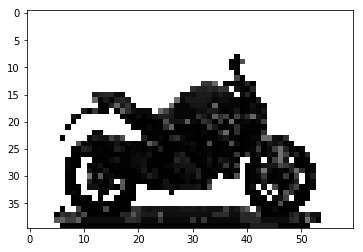

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[255.0,255.0,255....|[1.39426867053877...|[0.98265811434197...|       0.0|
+--------------------+--------------------+--------------------+----------+

False positive


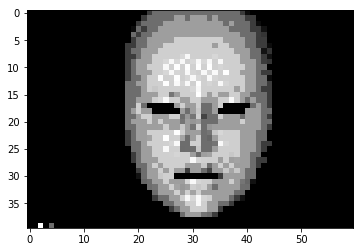

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[0.0,0.0,0.0,0.0,...|[-0.8628696806350...|[0.22229802512412...|       1.0|
+--------------------+--------------------+--------------------+----------+

False negative


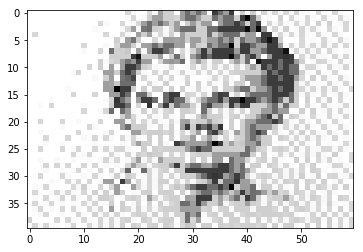

+--------------------+--------------------+--------------------+----------+
|              pixels|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[225.0,225.0,225....|[1.07328034542408...|[0.94867623994276...|       0.0|
+--------------------+--------------------+--------------------+----------+



In [22]:
# this code will display your solution
print("True positive")
display_image(TP_URL)
predict_image(face_model, TP_URL).show()
print("True negative")
display_image(TN_URL)
predict_image(face_model, TN_URL).show()
print("False positive")
display_image(FP_URL)
predict_image(face_model, FP_URL).show()
print("False negative")
display_image(FN_URL)
predict_image(face_model, FN_URL).show()

In [23]:
# 10 pts
assert 0 <= predict_image(face_model, TP_URL).first().prediction <= 1
assert 0 <= predict_image(face_model, TN_URL).first().prediction <= 1 
assert 0 <= predict_image(face_model, FP_URL).first().prediction <= 1
assert 0 <= predict_image(face_model, FN_URL).first().prediction <= 1

## **Question 4 (10 pts)**: 

Study neural network architectures to fit the infamous two-spirals dataset. There is boilerplate code to do the data generation, plotting and evaluation. Play with number of hidden layers and with the number of neurons per hidden layer but **limit the number of total weights to no more than 200 to achieve an accuracy greater than 70%**. *You can also increase the parameter `maxIter` to improve the performance*. The input dimension is 2 and the output dimension is 2. Use the convenience function `fit_and_plot` to fit an estimator. Assign the fitted model to a variable `ts_model`. Look at the example with logistic regression. 

In [24]:
# BOILERPLATE CODE
from sklearn import manifold, datasets
from pyspark.sql import Row
import numpy as np
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/330
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

# X, y = datasets.make_circles(n_samples=300, factor=.6, noise=.1, random_state=0)
data = spark.createDataFrame(  [Row(x=float(x[0]), y=float(x[1]), label=int(label)) for x, label in zip(X, y)])

plotting_data = spark.range(100).selectExpr("(id - 50)/3 as x").\
  crossJoin(spark.range(100).selectExpr("(id - 50)/3 as y"))

  
def fit_and_plot(estimator):
    """Plot the data and decision surface of estimator"""    
    
    plt.figure()
    va= feature.VectorAssembler(inputCols=['x', 'y'], outputCol='features')
    
    model = estimator.fit(va.transform(data))
    
    df = va.transform(plotting_data)    
    pp = model.transform(df).select('x', 'y', 'prediction').toPandas()

    fig, ax = plt.subplots(figsize=(5,5))
    plt.contourf(pp.x.unique(), pp.y.unique(), 
                 pp.prediction.values.reshape(pp.x.unique().shape[0], 
                                              pp.x.unique().shape[0]).T, alpha=0.5)
    colors=['blue', 'red']
    for i, grp in data.toPandas().groupby('label'):
        grp.plot(x='x', y='y', kind='scatter', ax=ax,color=colors[i])  

    acc = model.transform(va.transform(data)).\
        selectExpr('avg(CAST((label = prediction) AS FLOAT)) AS avg').first().avg
    plt.title('Accuracy = {}'.format(acc))
    plt.show()
    return model

def ts_accuracy(model):
    va= feature.VectorAssembler(inputCols=['x', 'y'], outputCol='features')
    acc = model.transform(va.transform(data)).\
        selectExpr('avg(CAST((label = prediction) AS FLOAT)) AS avg').first().avg
    return acc

<Figure size 432x288 with 0 Axes>

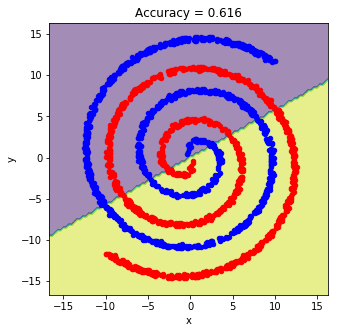

Model accuracy:  0.616


In [25]:
# example estimator that is not very good
# the plot shows the performance
ts_model = fit_and_plot(classification.LogisticRegression())
# but also you can examine it with ts_accuracy
print("Model accuracy: ", ts_accuracy(ts_model))

<Figure size 432x288 with 0 Axes>

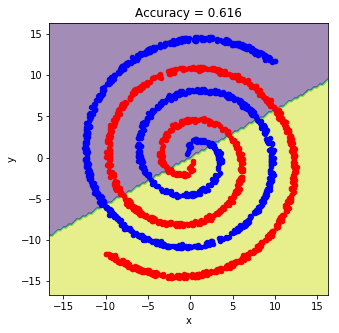

Model accuracy:  0.616


In [26]:
# example multilayer perceptron with no hidden layers
# the plot shows the performance
ts_model = fit_and_plot(classification.MultilayerPerceptronClassifier(layers=[2, 2]))
# but also you can examine it with ts_accuracy
print("Model accuracy: ", ts_accuracy(ts_model))

<Figure size 432x288 with 0 Axes>

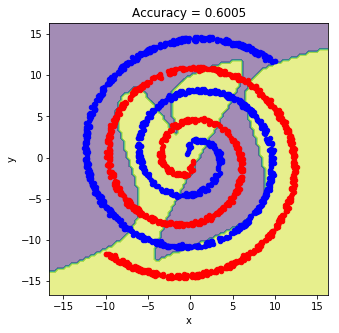

<Figure size 432x288 with 0 Axes>

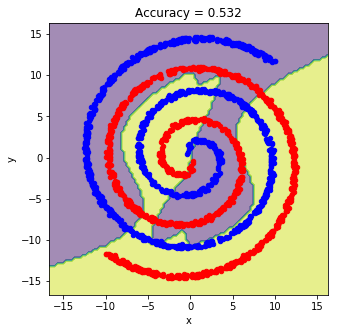

<Figure size 432x288 with 0 Axes>

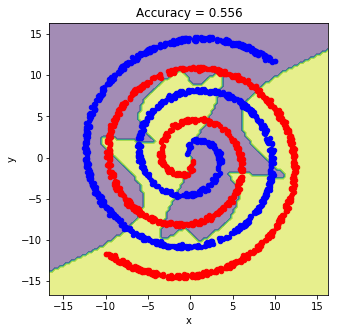

<Figure size 432x288 with 0 Axes>

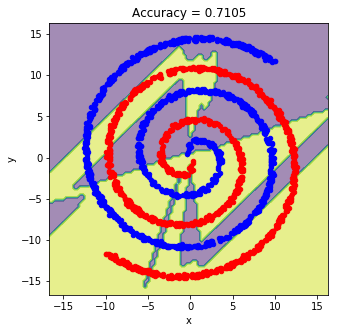

In [27]:
# YOUR CODE HERE

#I started with some initial values for number of neurons in each layer (5 each) and maximum iteraions (500). Made a loop
#to be executed 20 times at max. Inside the loop, I tried fitting 2 MLP models for each loop iteration; one with 2 hidden
#layers and one with 3, both with same maxIter. After fitting, I am checking for the number of total weights to be below 200.
#In case the models satisfy that condition, I am setting a flag. Then I am checking for the accuracy. Only if the accuracy
#is greater than 70% (0.7), then that model will be assigned to ts_model and the loop will break its execution. Else, the
#number of neurons would be incremented for the next iteration by 1 and the maximum iteration value will be incrememnted by 
#50 for the next iteration:

p=0
i=j=k=5
miter=500
while p<20:
    flag=0
    mlp1=classification.MultilayerPerceptronClassifier(layers=[2,i,j,2],maxIter=miter)
    m1=fit_and_plot(mlp1)
    
    mlp2=classification.MultilayerPerceptronClassifier(layers=[2,i,j,k,2],maxIter=miter)
    m2=fit_and_plot(mlp2)
    
    if len(m1.weights)<=200:    
        flag=flag+1
    if len(m2.weights)<=200:
        flag=flag+1
    
    if flag==2:
        if max(ts_accuracy(m1),ts_accuracy(m2))>0.7:
            if ts_accuracy(m1)>ts_accuracy(m2):
                ts_model=m1
                break
            else:
                ts_model=m2
                break
    elif flag==1:
        if ts_accuracy(m1)>0.7:
            ts_model=m1
            break
    p=p+1
    i=i+1
    j=j+1
    k=k+1
    miter=miter+50

#raise NotImplementedError()

In [28]:
# 10 pts
assert type(ts_model) == classification.MultilayerPerceptronClassificationModel
assert len(ts_model.weights) <= 200
np.testing.assert_array_less(0.7, ts_accuracy(ts_model))

**Question 5 (5 pts):**

### beat the professor!
Starting from the following Tensorflow Playground [here](http://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.00001&regularizationRate=0&noise=0&networkShape=4,2&seed=0.00846&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false),

change any of the following parameters and create a variable that contain the parameter you chose:

- Learning rate (`learning_rate`)
- Activation (`activation`)
- Regularization (`reg`)
- Regularization rate (`reg_rate`)
- Number of neurons per hidden layer (`hidden_layers`: this should be a list with the number of neurons for each hidden layer)

Usually, after you change any of the allowable parameters, you will need to restart the learning by pressing the *reset network* button and then pressing the *play* button.

But DO NOT CHANGE any of the following:

- Data
- Ratio of training to test data
- Noise
- Batch size
- Features

Report the parameters you use to achieve less than **0.01 test loss before 20,000 epochs**

In [29]:
# YOUR CODE HERE

learning_rate=0.03
activation="ReLU"
reg="L1"
reg_rate=0.001
hidden_layers=[8,8,5]

#raise NotImplementedError()

In [30]:
# 5 pts
assert type(learning_rate) == float
assert activation.upper() in ['RELU', 'SIGMOID', 'TANH', 'LINEAR']
assert reg.upper() in ['NONE', 'L1', 'L2']
assert reg_rate >= 0
assert type(hidden_layers) == list and len(hidden_layers) > 0

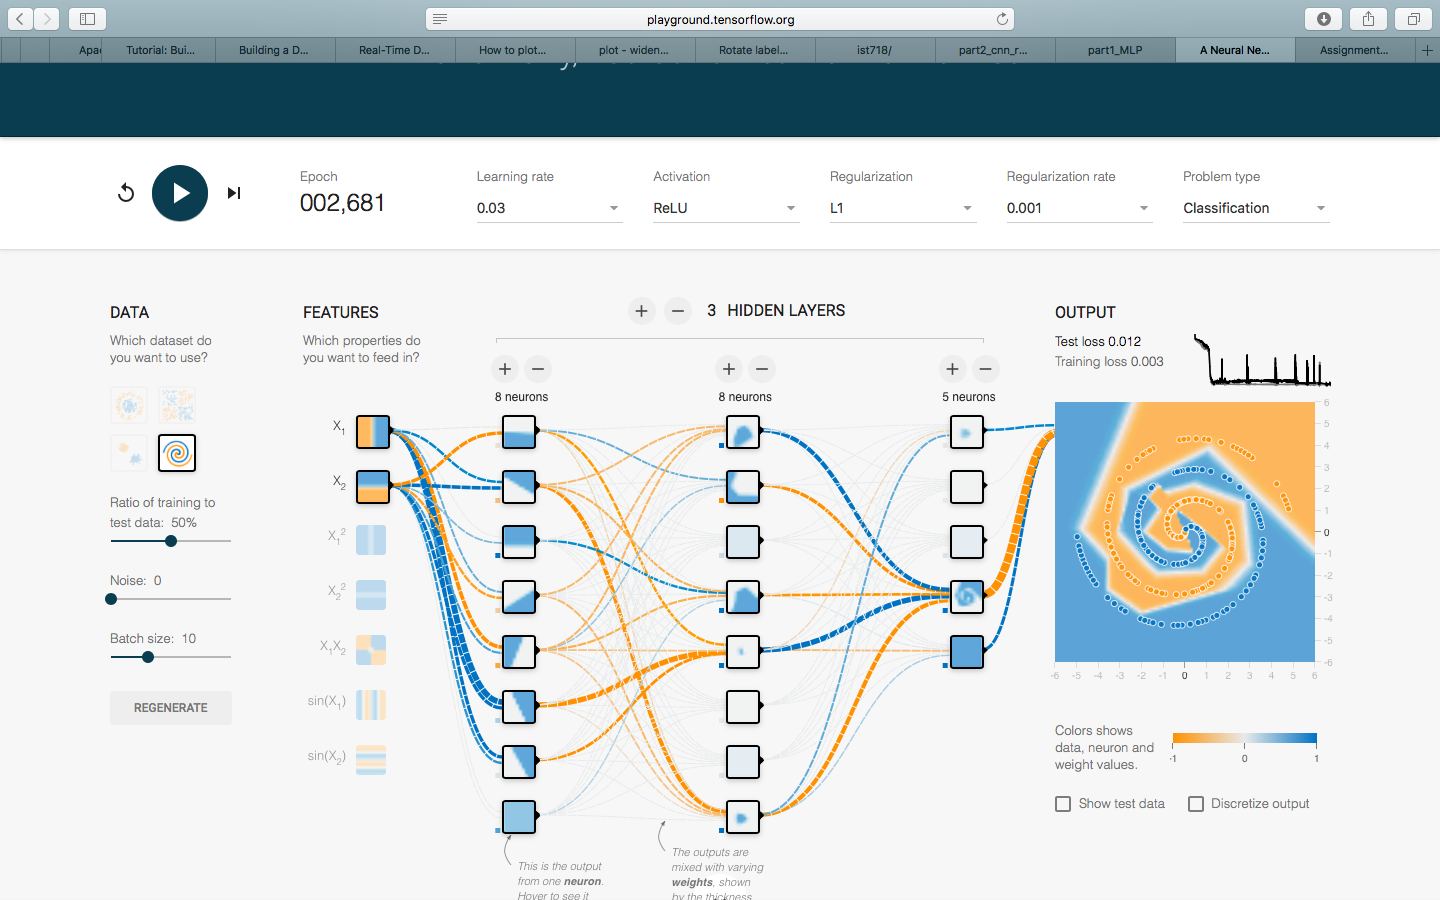

Took a screenshot in the middle of the execution.